In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import cv2
from collections import defaultdict

In [3]:
# ======= PATH ========
dataset_path = '/content/tomatoleaf/clean_tomato_dataset_td'
val_dir = os.path.join(dataset_path, 'val')
model_path = '/content/drive/MyDrive/brain_model/DenseNet121_GradCAM/densenet121_best.weights.h5'

In [4]:
# ======= DATA GENERATOR ========
val_datagen = ImageDataGenerator(rescale=1./255)
image_size = (224, 224)
batch_size = 32

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

Found 391 images belonging to 8 classes.


In [5]:
# ======= LOAD MODEL ========
def load_trained_model(weights_path):
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

    base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.load_weights(weights_path)
    return model

model = load_trained_model(model_path)

In [6]:
# ======= Grad-CAM Function ========
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
# ======= Overlay Function ========
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

In [8]:
# ======= Collect Images by Class ========
def collect_images_by_class(val_generator, num_images_per_class=5):
    class_images = defaultdict(list)
    for i, img_path in enumerate(val_generator.filepaths):
        class_name = img_path.split('/')[-2]
        if len(class_images[class_name]) < num_images_per_class:
            class_images[class_name].append(img_path)
        if all(len(images) >= num_images_per_class for images in class_images.values()):
            break
    return class_images

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


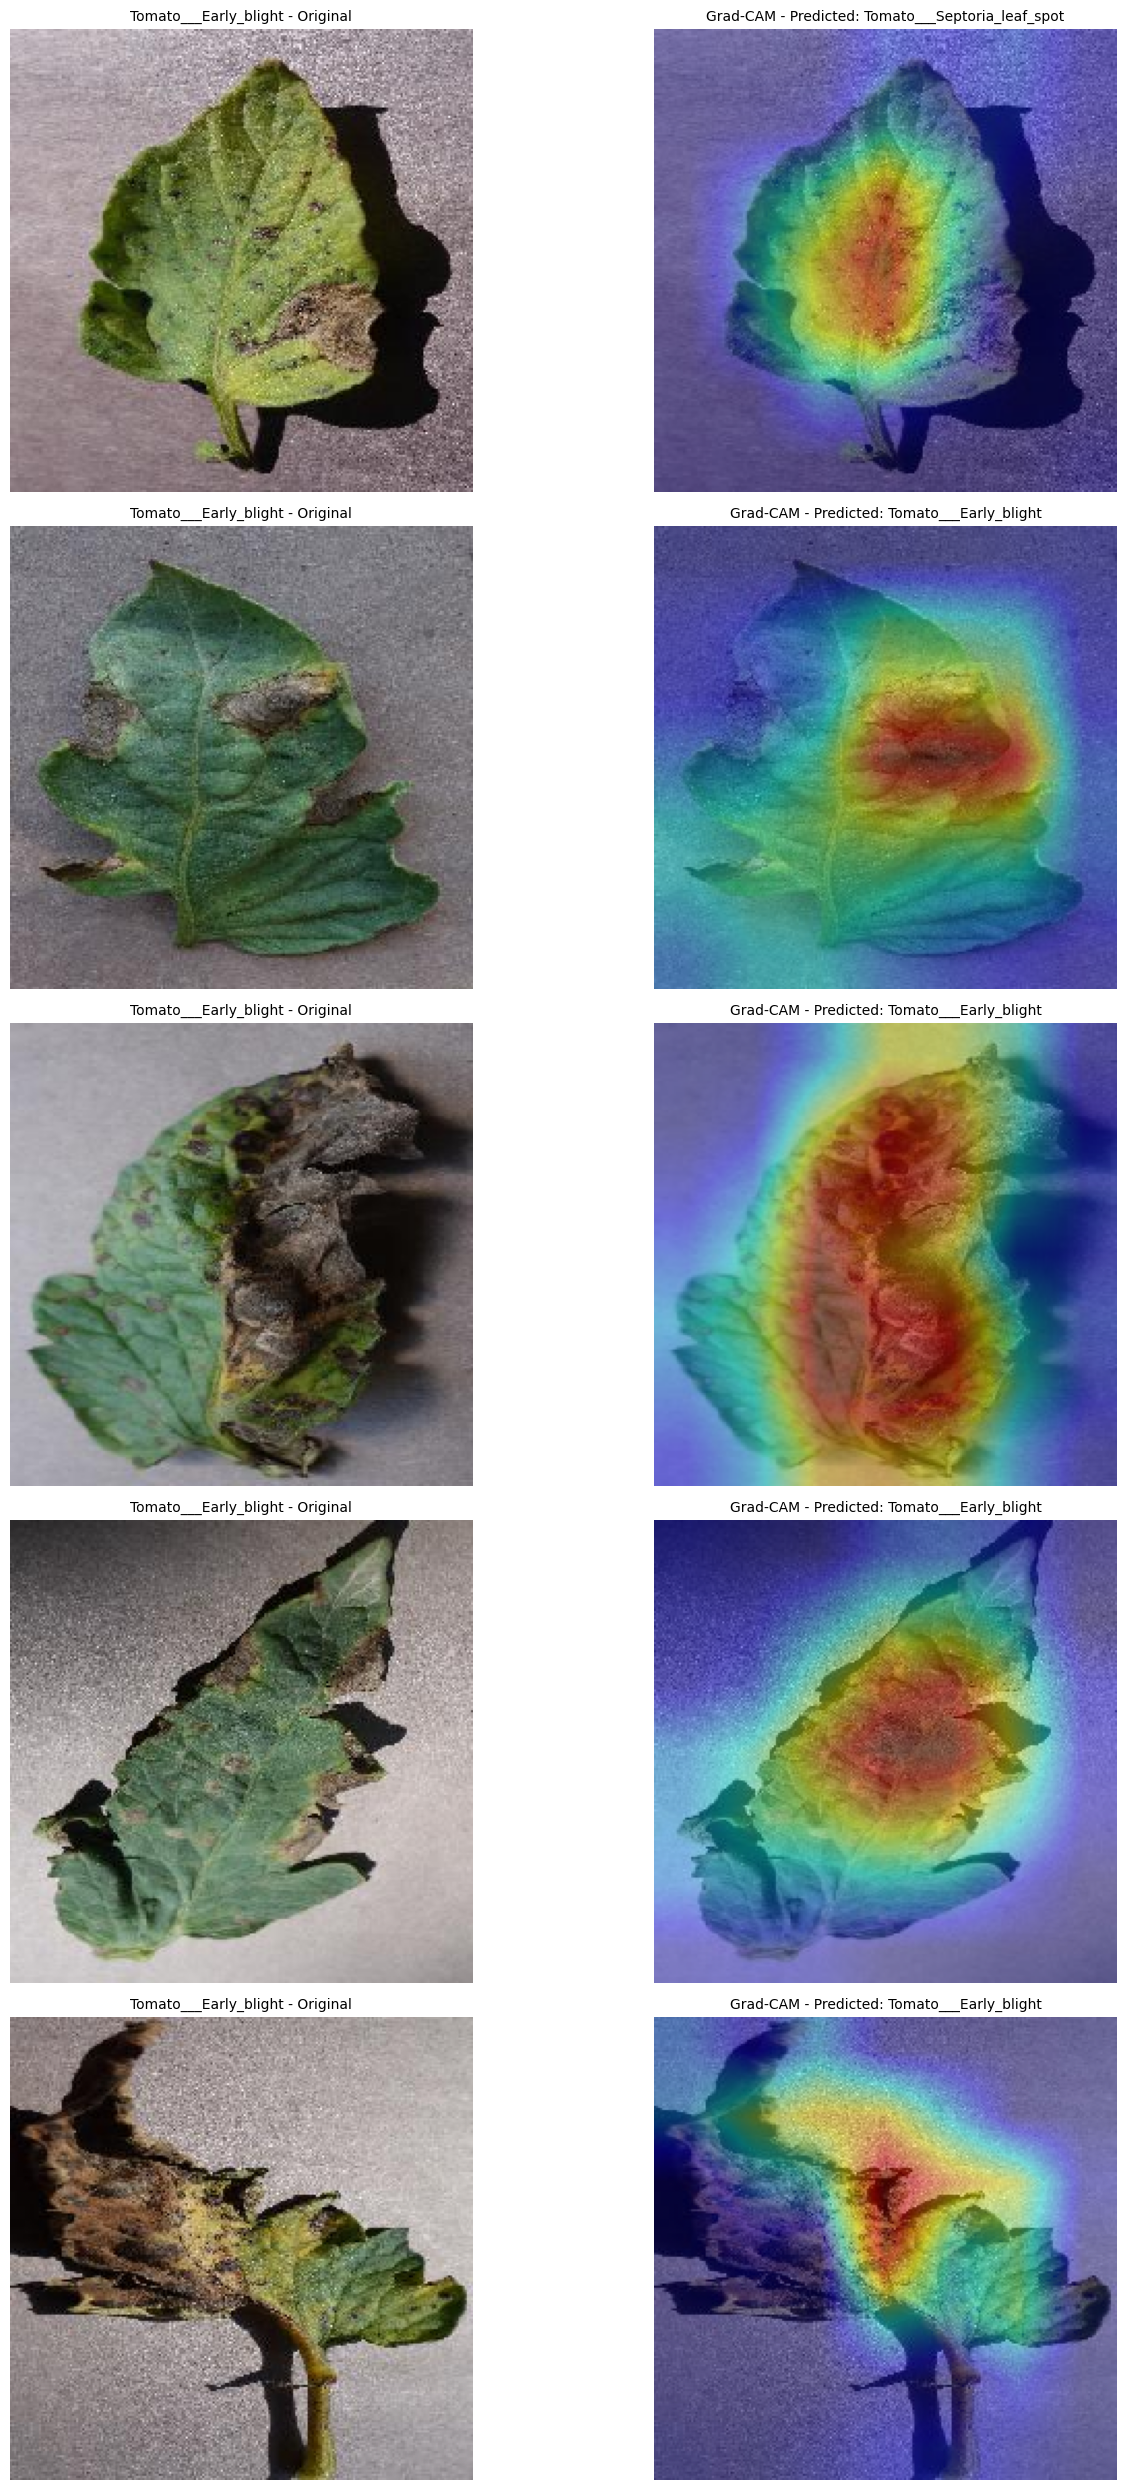

In [9]:
# ======= Plot Grad-CAM Images per Class ========
last_conv_layer_name = 'conv5_block16_concat'
class_images = collect_images_by_class(val_generator)

plt.figure(figsize=(15, 5 * len(class_images) * 5))

plot_idx = 1
for class_name, img_paths in class_images.items():
    for i, img_path in enumerate(img_paths):
        img = tf.keras.utils.load_img(img_path, target_size=image_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array / 255.0, axis=0)

        predictions = model.predict(img_array, verbose=0)
        pred_class_idx = np.argmax(predictions[0])
        pred_class = idx_to_class[pred_class_idx]

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_class_idx)
        superimposed_img = overlay_heatmap(img, heatmap)

        # Plot original image
        plt.subplot(len(class_images) * 5, 2, plot_idx)
        plt.imshow(img)
        plt.title(f"{class_name} - Original", fontsize=10)
        plt.axis('off')

        # Plot Grad-CAM image
        plt.subplot(len(class_images) * 5, 2, plot_idx + 1)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM - Predicted: {pred_class}", fontsize=10)
        plt.axis('off')

        plot_idx += 2

plt.tight_layout()
plt.show()